In [147]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import re
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_test.csv
/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_train.csv


In [148]:
# Load the training and testing datasets
train_df = pd.read_csv("/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_train.csv", encoding='ISO-8859-1')
test_df = pd.read_csv("/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_test.csv", encoding='ISO-8859-1')


In [149]:
# Preview the data
print(train_df.head())

   UserName  ScreenName   Location     TweetAt  \
0      3799       48751     London  16-03-2020   
1      3800       48752         UK  16-03-2020   
2      3801       48753  Vagabonds  16-03-2020   
3      3802       48754        NaN  16-03-2020   
4      3803       48755        NaN  16-03-2020   

                                       OriginalTweet           Sentiment  
0  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...             Neutral  
1  advice Talk to your neighbours family to excha...            Positive  
2  Coronavirus Australia: Woolworths to give elde...            Positive  
3  My food stock is not the only one which is emp...            Positive  
4  Me, ready to go at supermarket during the #COV...  Extremely Negative  


In [150]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [151]:
train_df['Sentiment'].unique()

array(['Neutral', 'Positive', 'Extremely Negative', 'Negative',
       'Extremely Positive'], dtype=object)

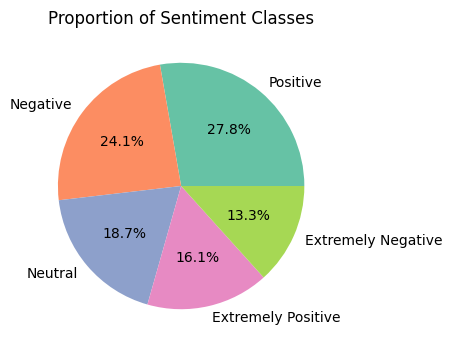

In [152]:
# Calculate the distribution
class_counts = train_df['Sentiment'].value_counts()

# Plot the pie chart
plt.figure(figsize=(4, 4))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', colors=sns.color_palette('Set2', len(class_counts)))

# Adding title
plt.title('Proportion of Sentiment Classes')

# Show the plot
plt.show()

In [153]:
# Preprocessing: Cleaning the text
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)  # remove URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # remove punctuation and numbers
    text = re.sub(r'\s+', ' ', text).strip()  # remove extra spaces
    return text

In [154]:
train_df['cleaned_tweet'] = train_df['OriginalTweet'].apply(clean_text)
test_df['cleaned_tweet'] = test_df['OriginalTweet'].apply(clean_text)

In [155]:
# Tokenization and Padding (fit tokenizer only on training data)
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(train_df['cleaned_tweet'])

In [156]:
# Convert the text to sequences
train_sequences = tokenizer.texts_to_sequences(train_df['cleaned_tweet'])
test_sequences = tokenizer.texts_to_sequences(test_df['cleaned_tweet'])

In [157]:
# Padding sequences to a fixed length
max_length = 100
X_train = pad_sequences(train_sequences, maxlen=max_length, padding='post')
X_test = pad_sequences(test_sequences, maxlen=max_length, padding='post')

In [158]:
# Encode the labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df['Sentiment'])
y_test = label_encoder.transform(test_df['Sentiment'])

In [159]:
# Convert labels to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, num_classes=5)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=5)

In [177]:
# Build the RNN model
model = Sequential([
    Embedding(input_dim=10000, output_dim=64, input_length=max_length),
    Bidirectional(GRU(64, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(GRU(32)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(5, activation='softmax')
])

In [178]:
optimizer = Adam(learning_rate=0.0005)

In [179]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [180]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [181]:
# Train the model with early stopping
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=128, callbacks=[early_stopping])

Epoch 1/50
322/322 ━━━━━━━━━━━━━━━━━━━━ 108s 309ms/step - accuracy: 0.3028 - loss: 1.5239 - val_accuracy: 0.5616 - val_loss: 1.0730
Epoch 2/50
322/322 ━━━━━━━━━━━━━━━━━━━━ 143s 311ms/step - accuracy: 0.6648 - loss: 0.8690 - val_accuracy: 0.6851 - val_loss: 0.8575
Epoch 3/50
322/322 ━━━━━━━━━━━━━━━━━━━━ 141s 308ms/step - accuracy: 0.7766 - loss: 0.6380 - val_accuracy: 0.7070 - val_loss: 0.8109
Epoch 4/50
322/322 ━━━━━━━━━━━━━━━━━━━━ 100s 311ms/step - accuracy: 0.8237 - loss: 0.5364 - val_accuracy: 0.7135 - val_loss: 0.8126
Epoch 5/50
322/322 ━━━━━━━━━━━━━━━━━━━━ 141s 308ms/step - accuracy: 0.8511 - loss: 0.4735 - val_accuracy: 0.7201 - val_loss: 0.8060
Epoch 6/50
322/322 ━━━━━━━━━━━━━━━━━━━━ 141s 305ms/step - accuracy: 0.8696 - loss: 0.4209 - val_accuracy: 0.7127 - val_loss: 0.8491
Epoch 7/50
322/322 ━━━━━━━━━━━━━━━━━━━━ 144s 312ms/step - accuracy: 0.8873 - loss: 0.3769 - val_accuracy: 0.7185 - val_loss: 0.8449
Epoch 8/50
322/322 ━━━━━━━━━━━━━━━━━━━━ 101s 312ms/step - accuracy: 0.9001 -

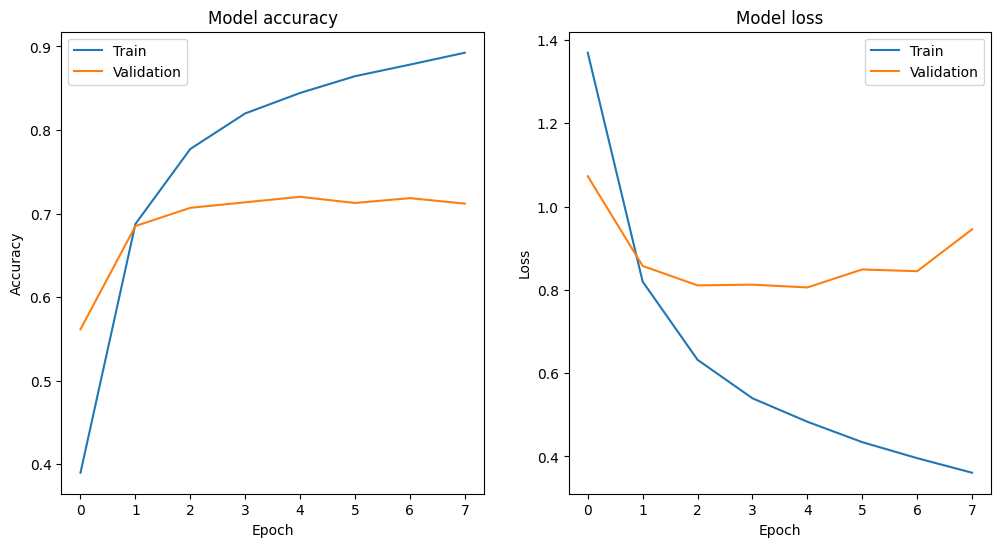

In [182]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

plt.show()

In [183]:
# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

119/119 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.7038 - loss: 0.8286
Test Accuracy: 72.01%


In [184]:
# Making predictions on the test data
predictions = model.predict(X_test)
predictions = np.round(predictions).astype(int)

119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step


In [186]:
# Show some predictions
for i in range(5):
    print(f"Tweet: {test_df['OriginalTweet'].iloc[i]}")
    print(f"Actual Label: {test_df['Sentiment'].iloc[i]}, Predicted Label: {predictions[i]}")

Tweet: TRENDING: New Yorkers encounter empty supermarket shelves (pictured, Wegmans in Brooklyn), sold-out online grocers (FoodKick, MaxDelivery) as #coronavirus-fearing shoppers stock up https://t.co/Gr76pcrLWh https://t.co/ivMKMsqdT1
Actual Label: Extremely Negative, Predicted Label: [0 0 1 0 0]
Tweet: When I couldn't find hand sanitizer at Fred Meyer, I turned to #Amazon. But $114.97 for a 2 pack of Purell??!!Check out how  #coronavirus concerns are driving up prices. https://t.co/ygbipBflMY
Actual Label: Positive, Predicted Label: [0 0 0 0 1]
Tweet: Find out how you can protect yourself and loved ones from #coronavirus. ?
Actual Label: Extremely Positive, Predicted Label: [0 1 0 0 0]
Tweet: #Panic buying hits #NewYork City as anxious shoppers stock up on food&amp;medical supplies after #healthcare worker in her 30s becomes #BigApple 1st confirmed #coronavirus patient OR a #Bloomberg staged event?

https://t.co/IASiReGPC4

#QAnon #QAnon2018 #QAnon2020 
#Election2020 #CDC https://t.c